# ML Workflow Notebook

Orchestrate the end-to-end classification pipeline loading functions from `src/` modules.

## Notebook Roadmap
- Prepare the ML dataset (targets and features)
- Assemble preprocessing and model candidates
- Run cross-validated training
- Evaluate on external dataset
- Analyse leaderboard and interpret the best model

In [22]:
%pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Bootstrap repository imports
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/annamelidi/Documents/Bispebjerg/ML


In [13]:
# Load configuration
from dataclasses import asdict
from src.utils.config import PipelineConfig, load_config
from src.utils.__init__ import set_global_seed

CONFIG_PATH = PROJECT_ROOT / "config/pipeline.yaml"
config = load_config(CONFIG_PATH)
asdict(config)
set_global_seed(config.random_state)

### Load and Prepare ML Dataset
It should contain the target(s) and features.

In [14]:
import pandas as pd
import numpy as np
from src.data.splits import prepare_train_holdout_split
from src.utils.config import PipelineConfig 

raw_data = pd.read_csv(config.data_path, sep='\t')
processed_data = pd.read_csv('../data/processed_data.tsv', sep='\t')
# collect list of all the proteins in the dataset
all_processed_proteins = processed_data.drop(['subject','sample','group'], axis = 1).columns.tolist()

# collect list of all the proteins that are not immunoglobulins in the dataset
not_igs = processed_data.columns[~processed_data.columns.str.contains('^IGH|^IGK|^IGL|^IGM|^IGG|^IGA')]
processed_data = processed_data[not_igs]

processed_data['combination']=pd.Series(pd.NA, index=processed_data.index, dtype="string")
processed_data.loc[processed_data.group.isin(['Virus','Bacteria']),'combination']='VB'
processed_data.loc[processed_data.group == 'MIS-C Acute Stage','combination']='MIS-C Acute Stage'
processed_data.to_csv("../data/processed_ML_data.tsv", sep="\t", index=False)

# Manually set holdout groups in the config file to match the publication
annotated_data, train_data, holdout_data = prepare_train_holdout_split(
    processed_data,
    config
)

# Rename target column in holdout data as VB and MIS-C During Admission
if not holdout_data.empty:
    holdout_data = holdout_data.copy()
    holdout_data['holdout_target'] = 'VB'
    holdout_data.loc[
        holdout_data['group'] == 'MIS-C During Admission',
        'holdout_target'
    ] = 'MIS-C During Admission'

features = train_data.drop(
    ['subject', 'sample', 'group', 'combination', 'study_split'],
    axis=1,
)
targets = train_data['combination']
holdout_features = None
holdout_targets = None
if not holdout_data.empty:
    holdout_features = holdout_data.drop(
        ['subject', 'sample', 'group', 'combination', 'study_split', 'holdout_target'],
        axis=1,
    )
    holdout_targets = holdout_data['holdout_target']



## Preprocessing Pipeline
To be imported from Anna's pipeline. Preprocessing is fit only on the training data within each fold (both inner and outer), and then applied to the corresponding validation or test data. 


To be edited according to needs of the study. 


In [15]:
from src.features.preprocess import build_preprocessor

preprocessor = build_preprocessor(features)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('row_zscore',
                                                  RowwiseZScoreScaler())]),
                                 ['A1BG~P04217', 'A2M~P01023', 'ACTA2~P62736',
                                  'ACTBL2~Q562R1', 'ACTB~P60709',
                                  'ADIPOQ~Q15848', 'AFM~P43652', 'AFP~P02771',
                                  'AGT~P01019', 'AHSG~P02765', 'ALB~P02768',
                                  'ALDOA~P04075', 'AMBP~P02760', 'ANPEP~P15144',
                                  'APCS~P02743', 'APMAP~Q9HDC9', 'APOA1~P02647',
                                  'APOA2~P02652', 'APOA4~P06727', 'APOB~P04114',
                                  'APOC1~P02654', 'APOC2~P02655',
                                  'APOC3~P02656', 'APOC4~P55056', 'APOD~P05090',
                                  'APOE~P02649', 'APOF~Q13790', 'APOH~P02749',
                                  'APOM~O95445', 'ATRN~O75882', ...]),
                                ('categorical',
                                 Pipeline(steps=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 [])])

## Model Registry

In [16]:
from src.models.estimators import build_models

models = build_models(config)
list(models.keys())

['logistic_regression', 'decision_tree']

## Nested Cross-Validation

![alt text](../Nested_CV.png)


In [17]:
from src.models.training import nested_cross_validate_models

leaderboard, trained_models = nested_cross_validate_models(
    models=models,
    preprocessor=preprocessor,
    X=features,
    y=targets,
    config=config,
)
leaderboard


/Users/annamelidi/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/annamelidi/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/annamelidi/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/annamelidi/Library/Python/3

,model,primary_metric,best_params_full_fit,selected_feature_count,selected_features,mean_f1_weighted,std_f1_weighted,mean_mcc,std_mcc,mean_roc_auc,std_roc_auc,fold_details
0,logistic_regression,f1_weighted,"{'estimator__solver': 'liblinear', 'estimator_...",5,"[numeric__CRP~P02741, numeric__FCGBP~Q9Y6R7, n...",0.933353,0.046653,0.864270,0.090642,0.976000,0.035777,"[{'outer_fold': 0, 'best_params': {'estimator_..."
1,decision_tree,f1_weighted,"{'estimator__splitter': 'random', 'estimator__...",165,"[numeric__APCS~P02743, numeric__APMAP~Q9HDC9, ...",0.832202,0.098848,0.646612,0.220119,0.868667,0.104419,"[{'outer_fold': 0, 'best_params': {'estimator_..."


NameError: name 'fold_results' is not defined

### Select Best Model

In [9]:
best_model_name = leaderboard.loc[0, "model"]
best_model = trained_models[best_model_name]
print(f"Best model: {best_model_name}")
best_model

Best model: logistic_regression


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('row_zscore',
                                                                   RowwiseZScoreScaler())]),
                                                  ['A1BG~P04217', 'A2M~P01023',
                                                   'ACTA2~P62736',
                                                   'ACTBL2~Q562R1',
                                                   'ACTB~P60709',
                                                   'ADIPOQ~Q15848',
                                                   'AFM~P43652', 'AFP~P02771',
                                                   'AGT~P01019', 'AHSG~P02765',
                                                   'ALB~P02768', 'ALDOA~P04075',
                                                   'AMBP~P02760',
                                                   'ANPEP~P15144',
                                                   'APCS~P02743',
                                                   'APMAP~Q9...
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False]))),
                ('estimator',
                 LogisticRegression(max_iter=5000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

# Visualizations from metrics
## ROC

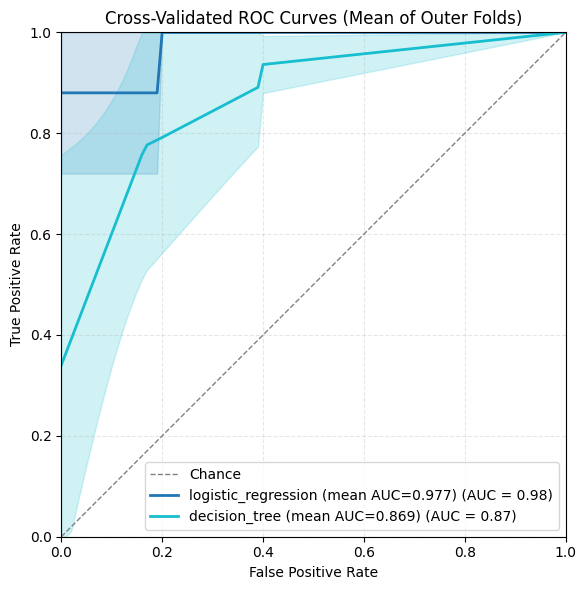

In [2]:
from pathlib import Path
from src.models.visualization import plot_cv_roc_curves_from_metrics

run_dir = Path("../outputs/runs/e7dd02c312ce/")  # or any run directory you want
fig = plot_cv_roc_curves_from_metrics("../outputs/runs/e7dd02c312ce/metrics.json",models=["logistic_regression", "decision_tree"], show=False) #choose the models to display or all


## Confusion Matrix

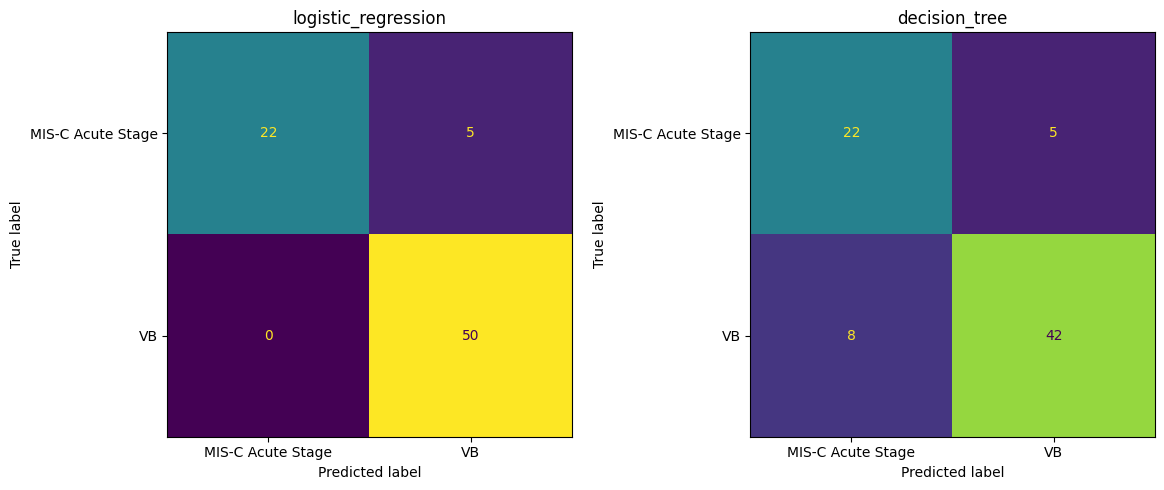

In [13]:
from src.models.visualization import plot_cv_confusion_matrices_from_metrics

fig = plot_cv_confusion_matrices_from_metrics(
    run_dir / "metrics.json",
    models=["logistic_regression", "decision_tree"],  # or leave out to show all models
    normalize=None,                  # "true", "pred", or "all" if you want rates
    show=False                      # whether to display the figure)
)


## Hold-out Evaluation

In [ ]:
import pandas as pd
from src.models.evaluation import evaluate_model_on_dataset

holdout_metrics = None
holdout_summary = None
holdout_predictions = None

if holdout_features is not None and holdout_targets is not None:
    # Map holdout targets to match training labels
    holdout_targets_mapped = holdout_targets.replace({'MIS-C During Admission': 'MIS-C Acute Stage'})
    holdout_metrics = evaluate_model_on_dataset(
        best_model,
        holdout_features,
        holdout_targets_mapped,
        positive_label="MIS-C Acute Stage"
    )
    holdout_summary = pd.DataFrame([
        {
            'dataset': 'holdout',
            'mcc': holdout_metrics['mcc'],
            'roc_auc': holdout_metrics['roc_auc'],
        }
    ])
    prediction_payload = {
        'y_true': holdout_metrics['y_true'],
        'y_pred': holdout_metrics['y_pred'],
    }
    if 'y_score' in holdout_metrics:
        prediction_payload['y_score'] = holdout_metrics['y_score']
    holdout_predictions = pd.DataFrame(prediction_payload)
    display(holdout_summary)
    display(holdout_predictions.head())
    estimator = getattr(getattr(best_model, 'named_steps', {}), 'get', lambda *_: None)('estimator')
    if estimator is None:
        estimator = best_model
    model_name = estimator.__class__.__name__
    mcc_value = holdout_metrics['mcc']
    print(f"Hold-out evaluation completed. {model_name} achieved MCC {mcc_value:.3f}")
else:
    print('Hold-out evaluation skipped: no hold-out dataset configured.')


/Users/annamelidi/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/annamelidi/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,dataset,mcc,roc_auc
0,holdout,0.613006,0.068323


,y_true,y_pred,y_score
0,1,1,0.198037
1,1,1,0.045876
2,1,1,0.048673
3,1,1,0.157597
4,1,0,0.746843


Hold-out evaluation completed. LogisticRegression achieved MCC 0.613


# Reuse Model

In [ ]:
import joblib

run_id = "619985d4122e"  # the run you want to reproduce

loaded_model = joblib.load(f"{config.output_dir}/runs/{run_id}/best_model.joblib")

# Use it for prediction in new data 
predictions = loaded_model.predict(new_data)

NameError: name 'new_data' is not defined